# Identifying the Abnormal Flamingos using Autoencoder

    The goal is to identify the abnormal flamingos from 100,000 quickdraw flamingos. An autoencoder is used to do dimension reduction. The flamingos with large-recovered errors are flagged "abnormal" or outliers.

By Yaohang

In [1]:
%matplotlib inline

import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras import models
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import Activation
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


## Load the data

In [2]:
flamingo = np.load('flamingo.npy')

## Add label to the data

In [3]:
# add a column with labels, 0=flamingo, 1=fish
flamingo = np.c_[flamingo, flamingo]

print(flamingo.shape)

(124569, 1568)


## Visualize the flamingos

In [4]:
def plot_samples(input_array, rows=4, cols=5, title=''):
    '''
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, surplus subplots remain empty.
    '''
    
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

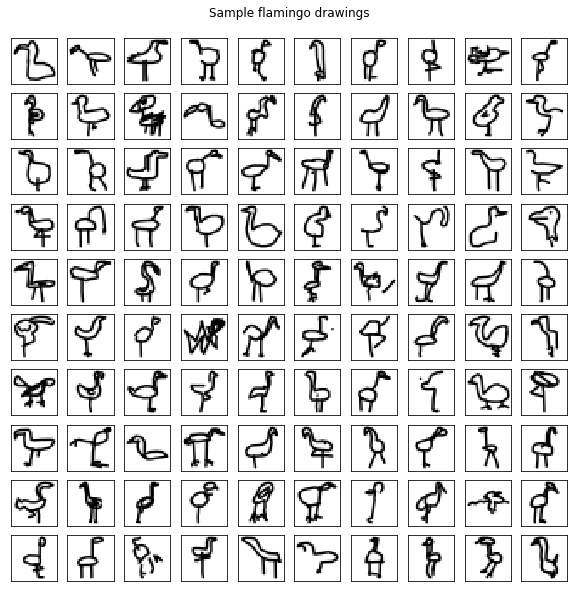

In [5]:
plot_samples(flamingo, rows=10, cols=10, title='Sample flamingo drawings\n')

## Split the training set and test set

In [6]:
from sklearn.model_selection import train_test_split

# merge the flamingo and fish arrays, and split the features (X) and labels (y). Convert to float32 to save some memory.
X = flamingo[:10000,:784].astype('float32') # all columns but the last
y = flamingo[:10000,784:].astype('float32') # the last column

# train/test split (divide by 255 to obtain normalized values between 0 and 1)
# I will use a 50:50 split, since I want to start by training the models on 5'000 samples and thus have plenty of samples to spare for testing.
X_train, X_test, y_train, y_test = train_test_split(X/255.,y/255.,test_size=0.5,random_state=0)
# X_test = np.append(X_test, bear[0, :784].reshape(1, 784)/255., axis = 0)
# y_test = np.append(y_test, bear[0, 784:].reshape(1, 784)/255., axis = 0)

In [7]:
X_test.shape

(5000, 784)

In [8]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
y_train = y_train.reshape(y_train.shape[0], 28, 28, 1).astype('float32')
y_test = y_test.reshape(y_test.shape[0], 28, 28, 1).astype('float32')

## Setup the autoencoder parameters
The autoencoder condenses the 28x28 image into an 8-dimensional latent vector.

In [9]:
# Network parameters
input_shape = (28, 28, 1)
batch_size = 128
kernel_size = 3

# size of latent vector
latent_dim = 2
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

## Build the autoencoder

In [10]:
# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=1,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
latent_vector (Dense)        (None, 2)                 100354    
Total params: 119,170
Trainable params: 119,170
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=1,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 50176)             150528    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         289       
_________________________________________________________________
decoder_output (Activation)  (None, 28, 28, 1)         0         
Total para

In [12]:
# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 2)                 119170    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         206209    
Total params: 325,379
Trainable params: 325,379
Non-trainable params: 0
_________________________________________________________________


In [13]:
autoencoder.compile(optimizer = 'adam',
                   loss = 'mse')

## Train the autoencoder

In [14]:
# Fit the model
autoencoder.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=100)
# Final evaluation of the model

Instructions for updating:
Use tf.cast instead.
Train on 5000 samples, validate on 5000 samples
Epoch 1/5
5000/5000 [==============================] - 41s 8ms/step - loss: 0.1033 - val_loss: 0.0812
Epoch 2/5
5000/5000 [==============================] - 37s 7ms/step - loss: 0.0764 - val_loss: 0.0705
Epoch 3/5
5000/5000 [==============================] - 37s 7ms/step - loss: 0.0689 - val_loss: 0.0681
Epoch 4/5
5000/5000 [==============================] - 38s 8ms/step - loss: 0.0679 - val_loss: 0.0677
Epoch 5/5
5000/5000 [==============================] - 39s 8ms/step - loss: 0.0672 - val_loss: 0.0667


## Run the autoencoder on the test set

In [15]:
y_predict = autoencoder.predict(X_test)

In [16]:
y_test = y_test.reshape(5000, 784)
y_predict = y_predict.reshape(5000, 784)
# mse = np.mean(np.power(y_test - y_predict, 2), axis=1)/np.sum(y_test, axis = 1)
mse = np.mean(np.fabs(y_test - y_predict), axis=1)

In [17]:
ind = np.argpartition(mse, -50)[-50:]

## These are the top-50 abnormal flamingos found by Autoencoder

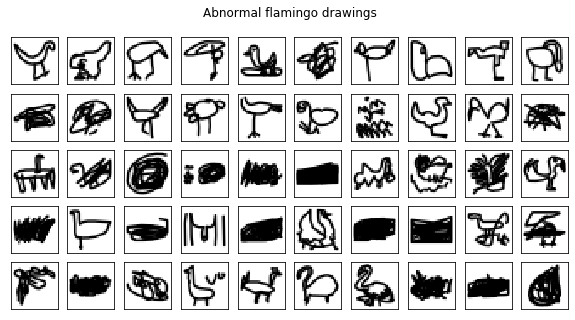

In [18]:
plot_samples(y_test[ind], rows = 5, cols = 10, title='Abnormal flamingo drawings\n')

## How the autoencoder convert the abnormal flamingo into a normal flamingo?

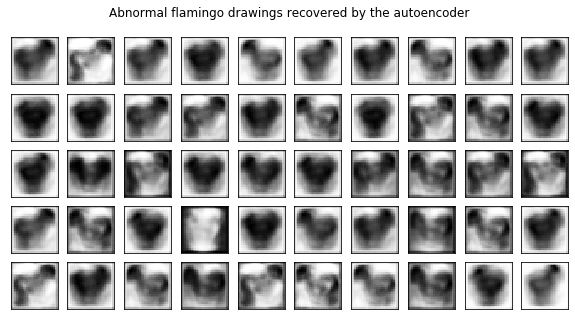

In [19]:
plot_samples(y_predict[ind], rows = 5, cols = 10, title='Abnormal flamingo drawings recovered by the autoencoder\n')

## The normal Flamingo should look like...

In [20]:
ind = np.argpartition(mse, 200)[0:200]

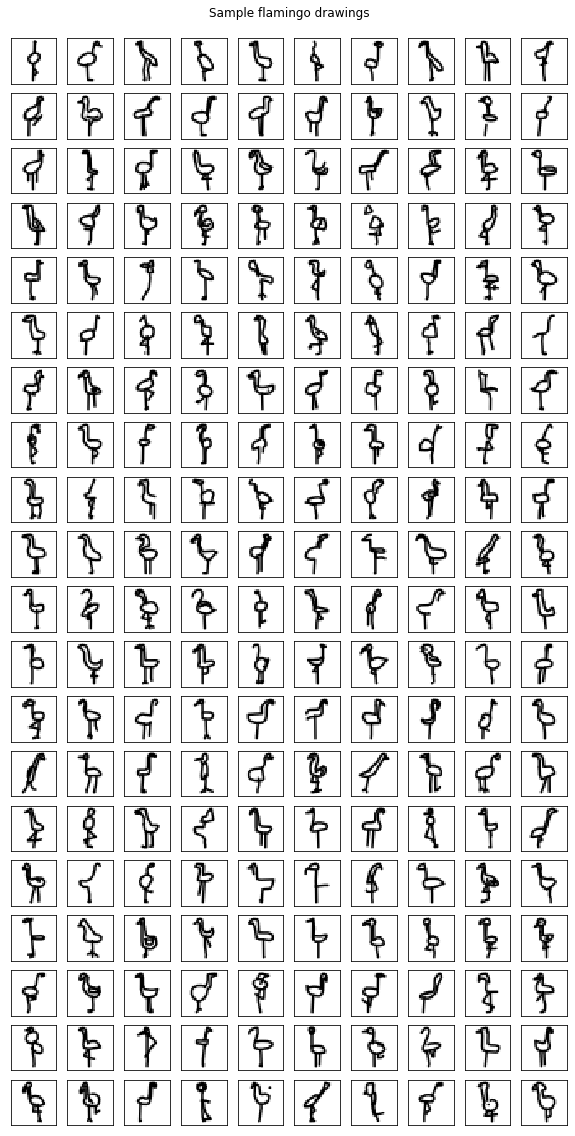

In [21]:
plot_samples(y_test[ind], rows=20, cols=10, title='Sample flamingo drawings\n')

## The latent vectors of flamingo space

In [22]:
latent = encoder.predict(X_test)

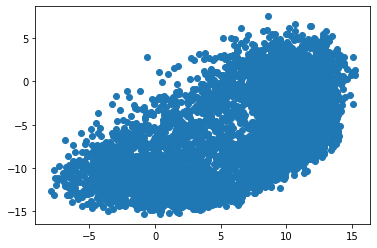

In [23]:
plt.scatter(latent[:, 0], latent[:, 1])

## Using One Class SVM to identify abnormal flamingos

In [24]:
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [30]:
outliers_fraction = 0.01
xx, yy = np.meshgrid(np.linspace(-7.5, 16, 150),
                     np.linspace(-15, 10, 150))
model = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.02)

In [31]:
model = model.fit(latent)
y_pred = model.predict(latent)

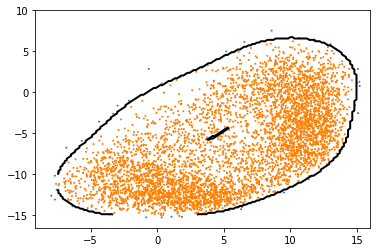

In [32]:
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
colors = np.array(['#377eb8', '#ff7f00'])
plt.scatter(latent[:, 0], latent[:, 1], s=1, color=colors[(y_pred + 1) // 2])
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.show()

In [33]:
ind = np.where(y_pred == -1)

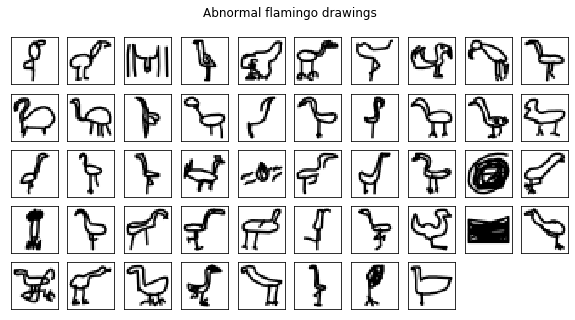

In [34]:
plot_samples(y_test[ind], rows = 5, cols = 10, title='Abnormal flamingo drawings\n')

## Using Isolation Forest to Identify Abnormal Flamingos

In [40]:
outliers_fraction = 0.01
xx, yy = np.meshgrid(np.linspace(-7.5, 15, 150),
                     np.linspace(-16, 10, 150))
model = IsolationForest(n_estimators = 1000, contamination=outliers_fraction, random_state=42)

In [41]:
model = model.fit(latent)
y_pred = model.predict(latent)

C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


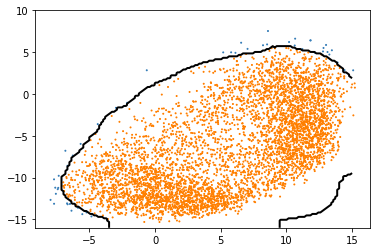

In [42]:
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
colors = np.array(['#377eb8', '#ff7f00'])
plt.scatter(latent[:, 0], latent[:, 1], s=1, color=colors[(y_pred + 1) // 2])
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.show()

In [43]:
ind = np.where(y_pred == -1)

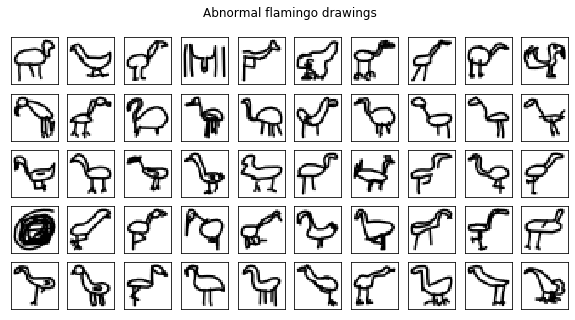

In [44]:
plot_samples(y_test[ind], rows = 5, cols = 10, title='Abnormal flamingo drawings\n')

## Using Local Outlier Factor (LOF) to identify Abnormal Flamingos

In [45]:
xx, yy = np.meshgrid(np.linspace(-4, 6, 150),
                     np.linspace(-4, 10, 150))
outliers_fraction = 0.01

model = LocalOutlierFactor(n_neighbors=1000, contamination=outliers_fraction)

In [46]:
y_pred = model.fit_predict(latent)

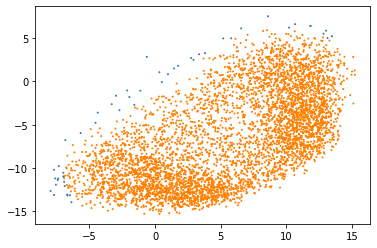

In [47]:
colors = np.array(['#377eb8', '#ff7f00'])
plt.scatter(latent[:, 0], latent[:, 1], s=1, color=colors[(y_pred + 1) // 2])
plt.show()

In [48]:
ind = np.where(y_pred == -1)

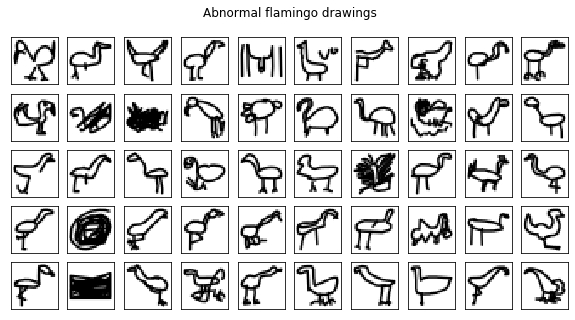

In [49]:
plot_samples(y_test[ind], rows = 5, cols = 10, title='Abnormal flamingo drawings\n')